In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['mesozooplankton']


# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            for var in ['mesozooplankton']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
   
# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(aggregates['mesozooplankton'][2015][:]))

(898, 398)


In [5]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['mesozooplankton']

### extraction code for thalweg data (mostly from nancy's fxns)

In [6]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.
    Reference: http://www.movable-type.co.uk/scripts/latlong.html
    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`
    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`
    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`
    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`
    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance_along_curve(lons, lats):
    """Calculate cumulative distance between points in lons, lats
    :arg lons: longitude points
    :type lons: numpy array
    :arg lats: latitude points
    :type lats: numpy array
    :returns: dist, a numpy array with distance along track
    """
    dist = [0]
    for i in np.arange(1, lons.shape[0]):
        newdist = dist[i-1] + haversine(lons[i], lats[i],
                                                  lons[i-1], lats[i-1])
        dist.append(newdist)
    dist = np.array(dist)
    return dist


def load_thalweg(
    gdept, lons, lats,
    filename='/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
):
    """Thalweg grid indices, depths and disatance.
    :arg gdept: full model depth array (shape 40x898x398)
    :type gdept: numpy array
    :arg lons: model longitude array (shape 898x398)
    :type lons: numpy array
    :arg lats: model latitude array (shape 898x398)
    :type lats: numpy array
    :returns: tpoints, gdept_thal, xx_thal
    An array of thalweg grid indices, depths and distance.
    """
    tpoints = np.loadtxt(filename, delimiter=' ', dtype=int)
    gdept_thal = gdept[:, tpoints[:, 0], tpoints[:, 1]]
    lons_thal = lons[tpoints[:, 0], tpoints[:, 1]]
    lats_thal = lats[tpoints[:, 0], tpoints[:, 1]]
    xx_thal = distance_along_curve(lons_thal, lats_thal)
    xx_thal = xx_thal + np.zeros(gdept_thal.shape)
    return tpoints, gdept_thal, xx_thal, lons_thal, lats_thal

### load required data

In [7]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
lons = grid_B['nav_lon'][:]
lats = grid_B['nav_lat'][:]
gdept = mesh_mask.variables['gdept_0'][0,:,:,:]

### use the load_thalweg function to get what we need

In [8]:
thalweg_points, gdept_thal, xx_thal, lons_thal, lats_thal = load_thalweg(gdept, lons, lats)
distance_along_thalweg = xx_thal[0,:]
thalweg_xs = thalweg_points[:,1]
thalweg_ys = thalweg_points[:,0]

### we now have several useful arrays that we can use in whatever map we want:

-lons_thal 
-lats_thal
-distance_along_thalweg
-thalweg_xs
-thalweg_ys

I haven't projected onto mapping software because I don't know what you use, but we can look at what we have just in a plot of thalweg points as lats and lons. We will highlight one point and annotate it

Text(-123.39826965332031, 48.197425842285156, '151 km')

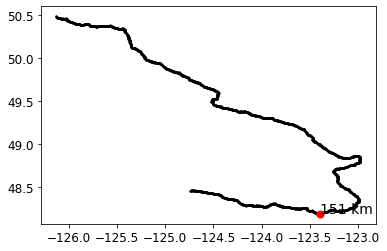

In [9]:


#what index along the thalweg do we want?
index_along_thalweg = 321
#here's the distance label
distance_label = f'{int(distance_along_thalweg[index_along_thalweg])} km'


#here we are plotting all the thalweg points
plt.scatter(lons_thal, lats_thal, marker = 'o', s = 2, color = 'k')

## here we are making the point that we wanted (above) red
plt.scatter(lons_thal[index_along_thalweg], lats_thal[index_along_thalweg],  marker = 'o', s = 50, color = 'r')
# here we are annotating it 
plt.text(lons_thal[index_along_thalweg], lats_thal[index_along_thalweg], distance_label, fontsize = 14)
#plt.xlabel('longitude')
#plt.ylabel('latitude')

Text(145, 826, '650 km')

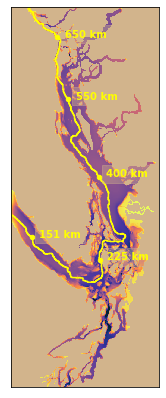

In [10]:

##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=5
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=100

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['mesozooplankton']['mean']*5.7*12/1000))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
#ax.set_title('Thalweg', fontsize=16)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
lines = lines.astype(int)

thalweg_x = lines[:, 0]
thalweg_y = lines[:, 1]

ax.plot(thalweg_y, thalweg_x, 'yellow')

#what index along the thalweg do we want?
index_along_thalweg1 = 108
index_along_thalweg2 = 480
index_along_thalweg3 = 849
index_along_thalweg4 = 1170
index_along_thalweg5 = 1383
#here's the distance label
distance_label1 = f'{int(distance_along_thalweg[index_along_thalweg1])} km'
distance_label2 = f'{int(distance_along_thalweg[index_along_thalweg2])} km'
distance_label3 = f'{int(distance_along_thalweg[index_along_thalweg3])} km'
distance_label4 = f'{int(distance_along_thalweg[index_along_thalweg4])} km'
distance_label5 = f'{int(distance_along_thalweg[index_along_thalweg5])} km'

#here we are plotting all the thalweg points
#plt.scatter(lons_thal, lats_thal, marker = 'o', s = 2, color = 'k')

## here we are making the point that we wanted (above) red
plt.scatter(thalweg_y[index_along_thalweg1], thalweg_x[index_along_thalweg1],  marker = 'o', s = 20, color = 'yellow')
plt.scatter(thalweg_y[index_along_thalweg2], thalweg_x[index_along_thalweg2],  marker = 'o', s = 20, color = 'yellow')
plt.scatter(thalweg_y[index_along_thalweg3], thalweg_x[index_along_thalweg3],  marker = 'o', s = 20, color = 'yellow')
plt.scatter(thalweg_y[index_along_thalweg4], thalweg_x[index_along_thalweg4],  marker = 'o', s = 20, color = 'yellow')
plt.scatter(thalweg_y[index_along_thalweg5], thalweg_x[index_along_thalweg5],  marker = 'o', s = 20, color = 'yellow')
# here we are annotating it 
plt.text(thalweg_y[index_along_thalweg1]+20, thalweg_x[index_along_thalweg1], distance_label, fontsize = 10,color='yellow',weight='bold',bbox=dict(facecolor='tan', alpha=0.4,edgecolor='tan')) #
plt.text(thalweg_y[index_along_thalweg2]+20, thalweg_x[index_along_thalweg2], distance_label2, fontsize = 10,color='yellow',weight='bold',bbox=dict(facecolor='tan', alpha=0.4,edgecolor='tan'))
plt.text(thalweg_y[index_along_thalweg3]+20, thalweg_x[index_along_thalweg3], distance_label3, fontsize = 10,color='yellow',weight='bold',bbox=dict(facecolor='tan', alpha=0.4,edgecolor='tan'))
plt.text(thalweg_y[index_along_thalweg4]+20, thalweg_x[index_along_thalweg4], distance_label4, fontsize = 10,color='yellow',weight='bold',bbox=dict(facecolor='tan', alpha=0.4,edgecolor='tan'))
plt.text(thalweg_y[index_along_thalweg5]+20, thalweg_x[index_along_thalweg5], distance_label5, fontsize = 10,color='yellow',weight='bold',bbox=dict(facecolor='tan', alpha=0.4,edgecolor='tan'))
#plt.xlabel('longitude')
#plt.xlabel('longitude')
#plt.ylabel('latitude')

#fig.colorbar(m0,ax=ax,label='(g C m$^{-2}$)')

#plt.savefig('Thalweg_Fig6.png', bbox_inches='tight',dpi=1000,transparent=False)